In [1]:
import math
from torch import nn, Tensor
import torch

In [2]:
vocab = ['a','b','c']

words = []
for i in vocab:
  for j in vocab:
    for k in vocab:
      words.append(i+j+k)


print('words',words)
vocab.append('0')
print('vocab',vocab)

letter_to_index = {letter: index for index, letter in enumerate(vocab)}
index_to_letter = {index: letter for index, letter in enumerate(vocab)}

word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}



#print(letter_to_index)
#print(index_to_letter)

#print(word_to_index)
#print(index_to_word)

N = len(words)
# includes special end of word character
V = len(vocab)
# includes end of word character
L = max(len(word) for word in words)+1

print('# of words',N)
print('# of chars',V)
print('seq len', L)

words ['aaa', 'aab', 'aac', 'aba', 'abb', 'abc', 'aca', 'acb', 'acc', 'baa', 'bab', 'bac', 'bba', 'bbb', 'bbc', 'bca', 'bcb', 'bcc', 'caa', 'cab', 'cac', 'cba', 'cbb', 'cbc', 'cca', 'ccb', 'ccc']
vocab ['a', 'b', 'c', '0']
# of words 27
# of chars 4
seq len 4


In [3]:
# Define the dimensions
# Prepare training set
X_train = []
Y_train = []

for word in words:

    chars = list(word)
    x = torch.zeros(1, L, N)
    y = torch.zeros(1, L)

    n = len(chars)
    for i in range(L):
        x[0, i, word_to_index[word]] = 1
        if i < n:
            y[0,i] = letter_to_index[chars[i]]
        else:
            y[0,i] = V-1

    X_train.append(x)
    Y_train.append(y)

# Convert the training set to tensors
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

# Print the shape of the training set
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
# prepare training set



X_train shape: torch.Size([27, 4, 27])
Y_train shape: torch.Size([27, 4])


In [31]:
# https://github.com/KasperGroesLudvigsen/influenza_transformer/blob/main/positional_encoder.py
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what
    the positional encoding layer does and why it is needed:

    "Since our model contains no recurrence and no convolution, in order for the
    model to make use of the order of the sequence, we must inject some
    information about the relative or absolute position of the tokens in the
    sequence." (Vaswani et al, 2017)
    Adapted from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self,
        dropout: float=0.1,
        max_seq_len: int=100,
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model

        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)


        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))


        if self.batch_first:

            pe = torch.zeros(1, max_seq_len, d_model)

            pe[0, :, 0::2] = torch.sin(position * div_term)

            pe[0, :, 1::2] = torch.cos(position * div_term)[:,:(d_model//2)]


        else:
            pe = torch.zeros(max_seq_len, 1, d_model)

            pe[:, 0, 0::2] = torch.sin(position * div_term)

            pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, max_seq_len=L):
        super(myRNN, self).__init__()
        self.input_size = input_size
        self.pos_encoder = PositionalEncoder(d_model = input_size, dropout=0.1, max_seq_len=max_seq_len)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        # h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        #h0 can be improved (h0 = x*toen_embedding)

        # Forward pass through RNN
        #out, _ = self.rnn(x, h0)
        x = x * math.sqrt(self.input_size)
        x = self.pos_encoder(x)
        out, _ = self.rnn(x)

        # Concatenate the output of RNN with y
        #out = torch.cat((out[:, -1, :], y.unsqueeze(1)), dim=1)
        # out = out[:, -1, :]

        # Pass the concatenated output through the fully connected layer
        out = self.fc(out)

        return out

myRNN(
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (rnn): RNN(27, 8, num_layers=3, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)
aaa aaa True
aab aab True
aac aac True
aba aba True
abb abb True
abc abc True
aca aca True
acb acb True
acc acc True
baa baa True
bab bab True
bac bac True
bba bba True
bbb bbb True
bbc bbc True
bca bca True
bcb bcb True
bcc bcc True
caa caa True
cab cab True
cac cac True
cba cba True
cbb cbb True
cbc cbc True
cca cca True
ccb ccb True
ccc ccc True
100.0


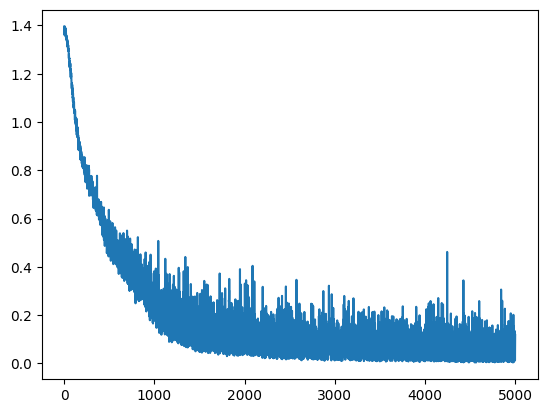

In [60]:
input_size = N
hidden_size = 2*V
num_classes = V
num_layers = 3
num_epochs = 5000
batch_size = 15
lr = 0.001

# Create an instance of the RNN model
model = myRNN(input_size, hidden_size, num_classes, num_layers=num_layers, max_seq_len=L)

# Print the model architecture
print(model)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Train the model


loss_acc = []
for epoch in range(num_epochs):
    # Shuffle the training data
    indices = torch.randperm(X_train.size(0))
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]

    # Split the training data into batches
    num_batches = X_train.size(0) // batch_size
    for batch_idx in range(num_batches):
        # Get the batch inputs and targets
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_inputs = X_train_shuffled[start_idx:end_idx]
        batch_targets = Y_train_shuffled[start_idx:end_idx]

        # Forward pass
        outputs = model(batch_inputs)

        # Compute the loss
        loss = criterion(outputs.view(-1, num_classes), batch_targets.view(-1).long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    loss_acc.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(loss_acc)

test_word_ids= list(range(0, N))
X_test = X_train[test_word_ids]

model.eval()
with torch.no_grad():
    outputs = model(X_test)

# Convert predictions to words
predicted_words = []
for output in outputs:
    predicted_word = ''
    for i in range(L):
        index = torch.argmax(output[i])
        if index == V-1:
            break
        predicted_word += index_to_letter[index.item()]
    predicted_words.append(predicted_word)


acc = 0
for i in range(len(test_word_ids)):
  w = words[test_word_ids[i]]
  wh = predicted_words[i]
  acc += w==wh
  print(w,wh, w==wh)
print(100*acc/N)

In [61]:
torch.save(model.state_dict(), "./detok_toy_trained_model_kron.pth")

In [62]:
# Get the weights of the RNN model
rnn_weights = model.rnn.state_dict()

# Visualize the weights
for name, weight in rnn_weights.items():
    print(f"Layer: {name}")
    print(weight.shape)
    print()


Layer: weight_ih_l0
torch.Size([8, 27])

Layer: weight_hh_l0
torch.Size([8, 8])

Layer: bias_ih_l0
torch.Size([8])

Layer: bias_hh_l0
torch.Size([8])

Layer: weight_ih_l1
torch.Size([8, 8])

Layer: weight_hh_l1
torch.Size([8, 8])

Layer: bias_ih_l1
torch.Size([8])

Layer: bias_hh_l1
torch.Size([8])

Layer: weight_ih_l2
torch.Size([8, 8])

Layer: weight_hh_l2
torch.Size([8, 8])

Layer: bias_ih_l2
torch.Size([8])

Layer: bias_hh_l2
torch.Size([8])

